# Initialization

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")


# Perceptrons

In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

y_pred

array([1])

Saving figure perceptron_iris_plot


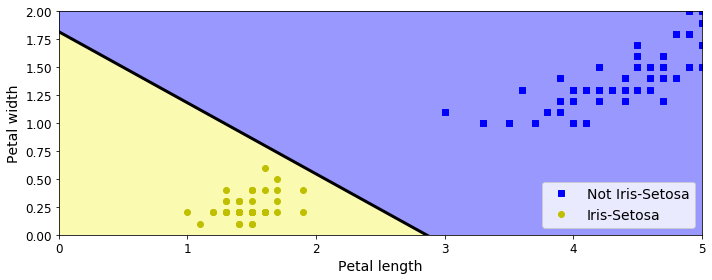

In [3]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

# Activation functions

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

Saving figure activation_functions_plot


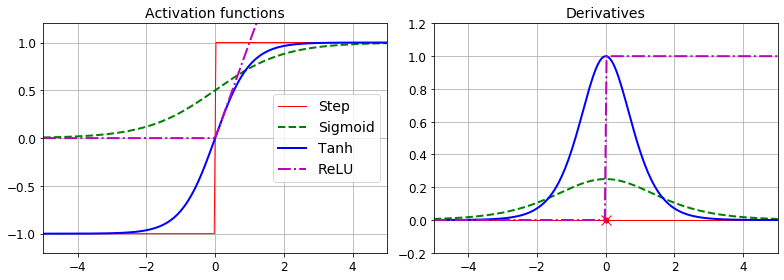

In [5]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

# Building an Image Classifier

In [6]:
import tensorflow as tf
from tensorflow import keras

In [7]:
tf.__version__

'2.1.0'

In [8]:
keras.__version__

'2.2.4-tf'

In [9]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [10]:
X_train_full.shape

(60000, 28, 28)

In [11]:
X_train_full.dtype

dtype('uint8')

Each pixel intensity is between (0 to 255)

In [12]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

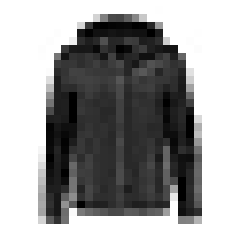

In [13]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [14]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [15]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [16]:
class_names[y_train[0]]

'Coat'

Saving figure fashion_mnist_plot


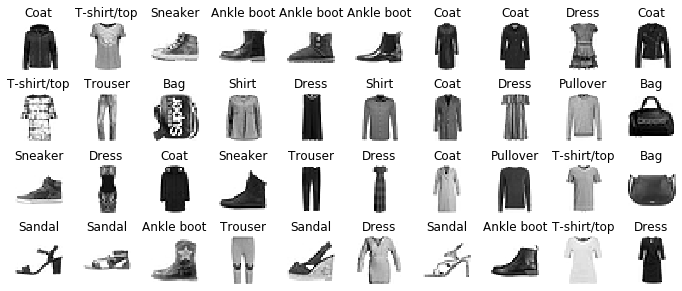

In [17]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [18]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [19]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [20]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [21]:
model.layers

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


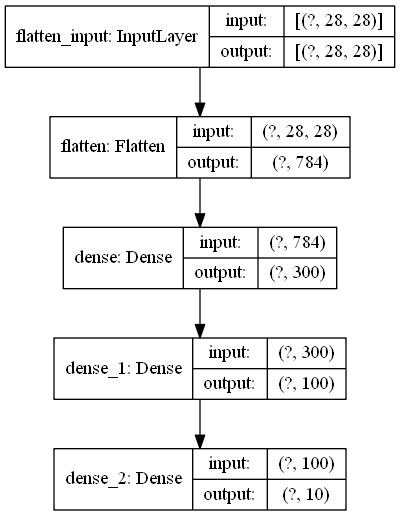

In [23]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [24]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [25]:
model.get_layer(hidden1.name) is hidden1

True

In [26]:
weights, biases = hidden1.get_weights()

In [27]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [28]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [29]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 3s 60us/sample - loss: 0.7226 - accuracy: 0.7641 - val_loss: 0.5073 - val_accuracy: 0.8320
Epoch 2/30
55000/55000 [==============================] - 3s 55us/sample - loss: 0.4843 - accuracy: 0.8322 - val_loss: 0.4543 - val_accuracy: 0.8484
Epoch 3/30
55000/55000 [==============================] - 3s 55us/sample - loss: 0.4414 - accuracy: 0.8462 - val_loss: 0.4379 - val_accuracy: 0.8486
Epoch 4/30
55000/55000 [==============================] - 3s 54us/sample - loss: 0.4129 - accuracy: 0.8547 - val_loss: 0.4156 - val_accuracy: 0.8564
Epoch 5/30
55000/55000 [==============================] - 3s 53us/sample - loss: 0.3926 - accuracy: 0.8619 - val_loss: 0.3811 - val_accuracy: 0.8654
Epoch 6/30
55000/55000 [==============================] - 3s 56us/sample - loss: 0.3771 - accuracy: 0.8668 - val_loss: 0.3727 - val_accuracy: 0.8692
Epoch 7/30
55000/55000 [==============================] -

In [30]:
history.params

{'batch_size': 32,
 'epochs': 30,
 'steps': 1719,
 'samples': 55000,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Saving figure keras_learning_curves_plot


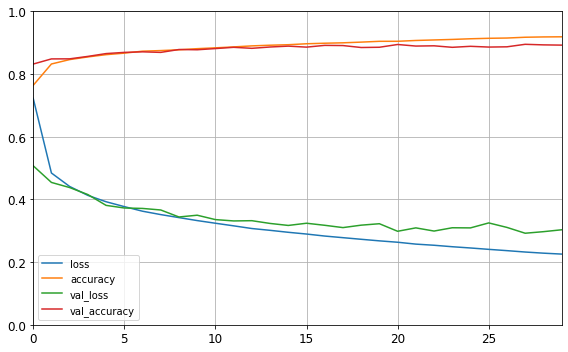

In [32]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [33]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 32us/sample - loss: 0.3358 - accuracy: 0.8782


[0.3358254776954651, 0.8782]

In [34]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.98],
       [0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [35]:
y_pred = model.predict_classes(X_new)
y_pred

array([9, 2, 1], dtype=int64)

In [36]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [37]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Saving figure fashion_mnist_images_plot


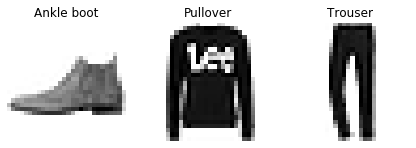

In [38]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# Regression MLP

In [39]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [40]:
np.random.seed(42)
tf.random.set_seed(42)

In [41]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 52us/sample - loss: 1.6205 - val_loss: 2.0374
Epoch 2/20
11610/11610 [==============================] - 0s 37us/sample - loss: 0.7162 - val_loss: 0.6571
Epoch 3/20
11610/11610 [==============================] - 0s 36us/sample - loss: 0.6356 - val_loss: 0.5996
Epoch 4/20
11610/11610 [==============================] - 0s 37us/sample - loss: 0.5989 - val_loss: 0.5662
Epoch 5/20
11610/11610 [==============================] - 0s 36us/sample - loss: 0.5713 - val_loss: 0.5489
Epoch 6/20
11610/11610 [==============================] - 0s 36us/sample - loss: 0.5491 - val_loss: 0.5204
Epoch 7/20
11610/11610 [==============================] - 0s 36us/sample - loss: 0.5301 - val_loss: 0.5018
Epoch 8/20
11610/11610 [==============================] - 0s 36us/sample - loss: 0.5142 - val_loss: 0.4815
Epoch 9/20
11610/11610 [==============================] - 0s 36us/sample - loss: 0.5004 - val_l

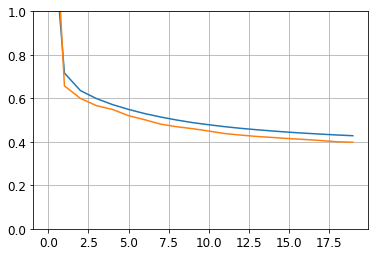

In [42]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [43]:
y_pred

array([[0.37310064],
       [1.6790789 ],
       [3.0817137 ]], dtype=float32)

# Functional API

In [44]:
np.random.seed(42)
tf.random.set_seed(42)

In [45]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [46]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           930         dense_5[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_6[0][0]                

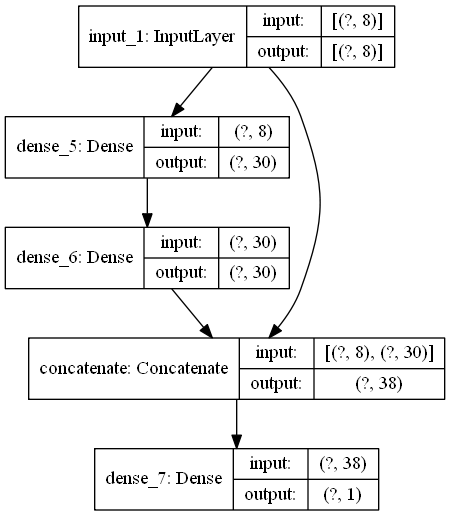

In [47]:
keras.utils.plot_model(model, "1.png", show_shapes=True)

In [48]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 56us/sample - loss: 1.2390 - val_loss: 0.6566
Epoch 2/20
11610/11610 [==============================] - 0s 40us/sample - loss: 0.6312 - val_loss: 0.6734
Epoch 3/20
11610/11610 [==============================] - 0s 39us/sample - loss: 0.5886 - val_loss: 0.5574
Epoch 4/20
11610/11610 [==============================] - 0s 38us/sample - loss: 0.5595 - val_loss: 0.5235
Epoch 5/20
11610/11610 [==============================] - 0s 39us/sample - loss: 0.5361 - val_loss: 0.5011
Epoch 6/20
11610/11610 [==============================] - 0s 39us/sample - loss: 0.5178 - val_loss: 0.5065
Epoch 7/20
11610/11610 [==============================] - 0s 39us/sample - loss: 0.5016 - val_loss: 0.4699
Epoch 8/20
11610/11610 [==============================] - 0s 39us/sample - loss: 0.4888 - val_loss: 0.4745
Epoch 9/20
11610/11610 [==============================] - 0s 39us/sample - loss: 0.4772 - val_l

Another example: we used features 0 to 4 for the wide path, features 2 to 7 for the deep path.

In [49]:
np.random.seed(42)
tf.random.set_seed(42)

In [50]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [51]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 57us/sample - loss: 1.8127 - val_loss: 2.1165
Epoch 2/20
11610/11610 [==============================] - 1s 44us/sample - loss: 0.6852 - val_loss: 0.6178
Epoch 3/20
11610/11610 [==============================] - 0s 40us/sample - loss: 0.5965 - val_loss: 0.5600
Epoch 4/20
11610/11610 [==============================] - 0s 41us/sample - loss: 0.5587 - val_loss: 0.5269
Epoch 5/20
11610/11610 [==============================] - 0s 40us/sample - loss: 0.5321 - val_loss: 0.5185
Epoch 6/20
11610/11610 [==============================] - 0s 40us/sample - loss: 0.5129 - val_loss: 0.4803
Epoch 7/20
11610/11610 [==============================] - 0s 40us/sample - loss: 0.4959 - val_loss: 0.4689
Epoch 8/20
11610/11610 [==============================] - 0s 40us/sample - loss: 0.4837 - val_loss: 0.4498
Epoch 9/20
11610/11610 [==============================] - 0s 40us/sample - loss: 0.4734 - val_l

Adding an auxiliary output for regularization:

In [52]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [53]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

In [54]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 74us/sample - loss: 2.0867 - main_output_loss: 1.8375 - aux_output_loss: 4.3229 - val_loss: 1.7305 - val_main_output_loss: 1.1226 - val_aux_output_loss: 7.1969
Epoch 2/20
11610/11610 [==============================] - 1s 49us/sample - loss: 0.9835 - main_output_loss: 0.7834 - aux_output_loss: 2.7860 - val_loss: 1.3301 - val_main_output_loss: 0.6998 - val_aux_output_loss: 6.9993
Epoch 3/20
11610/11610 [==============================] - 1s 45us/sample - loss: 0.8089 - main_output_loss: 0.6704 - aux_output_loss: 2.0544 - val_loss: 1.2302 - val_main_output_loss: 0.6118 - val_aux_output_loss: 6.7919
Epoch 4/20
11610/11610 [==============================] - 1s 44us/sample - loss: 0.7213 - main_output_loss: 0.6127 - aux_output_loss: 1.6975 - val_loss: 1.1911 - val_main_output_loss: 0.5980 - val_aux_output_loss: 6.5246
Epoch 5/20
11610/11610 [==============================] - 1s 44us/s

In [55]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

5160/5160 [==============================] - 0s 25us/sample - loss: 0.4822 - main_output_loss: 0.4277 - aux_output_loss: 0.9766


# The subclassing API

In [56]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [57]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 87us/sample - loss: 2.4897 - output_1_loss: 2.3161 - output_2_loss: 4.0451 - val_loss: 2.0961 - val_output_1_loss: 1.8751 - val_output_2_loss: 4.0797
Epoch 2/10
11610/11610 [==============================] - 1s 44us/sample - loss: 0.9934 - output_1_loss: 0.8363 - output_2_loss: 2.4100 - val_loss: 0.9892 - val_output_1_loss: 0.7246 - val_output_2_loss: 3.3681
Epoch 3/10
11610/11610 [==============================] - 0s 43us/sample - loss: 0.7877 - output_1_loss: 

# Saving and Restoring

In [58]:
np.random.seed(42)
tf.random.set_seed(42)

In [59]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [60]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 57us/sample - loss: 1.8423 - val_loss: 5.2165
Epoch 2/10
11610/11610 [==============================] - 0s 37us/sample - loss: 0.6876 - val_loss: 0.7732
Epoch 3/10
11610/11610 [==============================] - 0s 38us/sample - loss: 0.5954 - val_loss: 0.5446
Epoch 4/10
11610/11610 [==============================] - 0s 37us/sample - loss: 0.5553 - val_loss: 0.5425
Epoch 5/10
11610/11610 [==============================] - 0s 38us/sample - loss: 0.5268 - val_loss: 0.5539
Epoch 6/10
11610/11610 [==============================] - 0s 37us/sample - loss: 0.5049 - val_loss: 0.4701
Epoch 7/10
11610/11610 [==============================] - 0s 37us/sample - loss: 0.4852 - val_loss: 0.4562
Epoch 8/10
11610/11610 [==============================] - 0s 38us/sample - loss: 0.4706 - val_loss: 0.4452
Epoch 9/10
11610/11610 [==============================] - 0s 37us/sample - loss: 0.4576 - val_l

In [61]:
model.save("my_keras_model.h5")

In [62]:
model = keras.models.load_model("my_keras_model.h5")

In [63]:
model.predict(X_new)

array([[0.551559 ],
       [1.6555369],
       [3.0014234]], dtype=float32)

In [65]:
model.save_weights("my_keras_weights_1.ckpt")

In [66]:
model.load_weights("my_keras_weights_1.ckpt")

# Using Callbacks during Training

In [67]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [68]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [69]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 56us/sample - loss: 1.8423 - val_loss: 5.2165
Epoch 2/10
11610/11610 [==============================] - 0s 39us/sample - loss: 0.6876 - val_loss: 0.7732
Epoch 3/10
11610/11610 [==============================] - 0s 39us/sample - loss: 0.5954 - val_loss: 0.5446
Epoch 4/10
11610/11610 [==============================] - 0s 40us/sample - loss: 0.5553 - val_loss: 0.5425
Epoch 5/10
11610/11610 [==============================] - 0s 37us/sample - loss: 0.5268 - val_loss: 0.5539
Epoch 6/10
11610/11610 [==============================] - 0s 40us/sample - loss: 0.5049 - val_loss: 0.4701
Epoch 7/10
11610/11610 [==============================] - 0s 40us/sample - loss: 0.4852 - val_loss: 0.4562
Epoch 8/10
11610/11610 [==============================] - 0s 40us/sample - loss: 0.4706 - val_loss: 0.4452
Epoch 9/10
11610/11610 [==============================] - 0s 38us/sample - loss: 0.4576 - val_l

In [70]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 54us/sample - loss: 0.4385 - val_loss: 0.4287
Epoch 2/100
11610/11610 [==============================] - 0s 38us/sample - loss: 0.4319 - val_loss: 0.4117
Epoch 3/100
11610/11610 [==============================] - 0s 39us/sample - loss: 0.4252 - val_loss: 0.3975
Epoch 4/100
11610/11610 [==============================] - 0s 39us/sample - loss: 0.4199 - val_loss: 0.3943
Epoch 5/100
11610/11610 [==============================] - 0s 37us/sample - loss: 0.4150 - val_loss: 0.3964
Epoch 6/100
11610/11610 [==============================] - 0s 39us/sample - loss: 0.4110 - val_loss: 0.3907
Epoch 7/100
11610/11610 [==============================] - 0s 41us/sample - loss: 0.4070 - val_loss: 0.3823
Epoch 8/100
11610/11610 [==============================] - 0s 43us/sample - loss: 0.4036 - val_loss: 0.3786
Epoch 9/100
11610/11610 [==============================] - 0s 40us/sample - loss: 0.400

11610/11610 [==============================] - 0s 37us/sample - loss: 0.3345 - val_loss: 0.3476
Epoch 76/100
11610/11610 [==============================] - 0s 37us/sample - loss: 0.3341 - val_loss: 0.3196
Epoch 77/100
11610/11610 [==============================] - 0s 37us/sample - loss: 0.3338 - val_loss: 0.3608
Epoch 78/100
11610/11610 [==============================] - 0s 37us/sample - loss: 0.3336 - val_loss: 0.3295
Epoch 79/100
11610/11610 [==============================] - 0s 40us/sample - loss: 0.3331 - val_loss: 0.3927
Epoch 80/100
11610/11610 [==============================] - 0s 40us/sample - loss: 0.3332 - val_loss: 0.3167
Epoch 81/100
11610/11610 [==============================] - 0s 37us/sample - loss: 0.3317 - val_loss: 0.3783
Epoch 82/100
11610/11610 [==============================] - 0s 37us/sample - loss: 0.3322 - val_loss: 0.3154
Epoch 83/100
11610/11610 [==============================] - 0s 37us/sample - loss: 0.3315 - val_loss: 0.3538
Epoch 84/100
11610/11610 [======

In [71]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [72]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

Train on 11610 samples, validate on 3870 samples
10464/11610 [==========================>...] - ETA: 0s - loss: 0.3204
val/train: 1.16
11610/11610 [==============================] - 0s 38us/sample - loss: 0.3256 - val_loss: 0.3785


# TensorBoard

In [73]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [74]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2020_11_10-12_30_31'

In [75]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [76]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [77]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11610/11610 [==============================] - 1s 62us/sample - loss: 1.8423 - val_loss: 5.2165
Epoch 2/30
11610/11610 [==============================] - 1s 45us/sample - loss: 0.6876 - val_loss: 0.7732
Epoch 3/30
11610/11610 [==============================] - 1s 44us/sample - loss: 0.5954 - val_loss: 0.5446
Epoch 4/30
11610/11610 [==============================] - 1s 44us/sample - loss: 0.5553 - val_loss: 0.5425
Epoch 5/30
11610/11610 [==============================] - 1s 44us/sample - loss: 0.5268 - val_loss: 0.5539
Epoch 6/30
11610/11610 [==============================] - 1s 43us/sample - loss: 0.5049 - val_loss: 0.4701
Epoch 7/30
11610/11610 [==============================] - 1s 44us/sample - loss: 0.4852 - val_loss: 0.4562
Epoch 8/30
11610/11610 [==============================] - 1s 45us/sample - loss: 0.4706 - val_loss: 0.4452
Epoch 9/30
11610/11610 [==============================] - 1s 44us/sample - loss: 0.4576 - val_l

To start the TensorBoard server, use terminal:
```
$ tensorboard --logdir=./my_logs --port=6006
```
Then, in a web browser, use localhost:6006. Once you are done, press Ctrl-C in the terminal to shutdown the TensorBoard server.

Alternatively, use the Jupyter extension:

In [78]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

Reusing TensorBoard on port 6006 (pid 692), started 3:20:19 ago. (Use '!kill 692' to kill it.)

In [79]:
run_logdir2 = get_run_logdir() # make a new TF-board callback with a different name for another model
run_logdir2

'.\\my_logs\\run_2020_11_10-12_30_47'

In [80]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [81]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.05))

In [82]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11610/11610 [==============================] - 1s 73us/sample - loss: 5.6341 - val_loss: 1.3205
Epoch 2/30
11610/11610 [==============================] - 1s 49us/sample - loss: 1.2704 - val_loss: 1.0757
Epoch 3/30
11610/11610 [==============================] - 1s 47us/sample - loss: 0.9370 - val_loss: 0.7769
Epoch 4/30
11610/11610 [==============================] - 1s 45us/sample - loss: 0.8854 - val_loss: 0.8254
Epoch 5/30
11610/11610 [==============================] - 1s 44us/sample - loss: 0.9501 - val_loss: 0.9415
Epoch 6/30
11610/11610 [==============================] - 1s 45us/sample - loss: 0.8283 - val_loss: 0.6111
Epoch 7/30
11610/11610 [==============================] - 1s 47us/sample - loss: 0.8095 - val_loss: 0.7394
Epoch 8/30
11610/11610 [==============================] - 1s 46us/sample - loss: 1.1857 - val_loss: 1.0356
Epoch 9/30
11610/11610 [==============================] - 1s 47us/sample - loss: 0.8920 - val_l

# Hyperparameter Tuning

In [83]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [84]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [85]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [86]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 54us/sample - loss: 1.1399 - val_loss: 24.4309
Epoch 2/100
11610/11610 [==============================] - 0s 36us/sample - loss: 0.7393 - val_loss: 3.2896
Epoch 3/100
11610/11610 [==============================] - 0s 40us/sample - loss: 0.5374 - val_loss: 0.6080
Epoch 4/100
11610/11610 [==============================] - 0s 40us/sample - loss: 0.4796 - val_loss: 0.4532
Epoch 5/100
11610/11610 [==============================] - 0s 36us/sample - loss: 0.4536 - val_loss: 0.4221
Epoch 6/100
11610/11610 [==============================] - 0s 39us/sample - loss: 0.4373 - val_loss: 0.4144
Epoch 7/100
11610/11610 [==============================] - 0s 37us/sample - loss: 0.4256 - val_loss: 0.4025
Epoch 8/100
11610/11610 [==============================] - 0s 37us/sample - loss: 0.4178 - val_loss: 0.3938
Epoch 9/100
11610/11610 [==============================] - 0s 36us/sample - loss: 0.41

In [87]:
mse_test = keras_reg.score(X_test, y_test)

5160/5160 [==============================] - 0s 21us/sample - loss: 0.3464


In [88]:
y_pred = keras_reg.predict(X_new)

In [89]:
np.random.seed(42)
tf.random.set_seed(42)

In [90]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [(0), (1), (2), (3)],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] learning_rate=0.001683454924600351, n_hidden=0, n_neurons=15 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


7740/7740 [==============================] - 0s 59us/sample - loss: 3.5574 - val_loss: 1.8536
Epoch 2/100
7740/7740 [==============================] - 0s 37us/sample - loss: 1.3316 - val_loss: 0.9380
Epoch 3/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.8573 - val_loss: 0.8545
Epoch 4/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.7344 - val_loss: 0.9545
Epoch 5/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.6943 - val_loss: 0.7248
Epoch 6/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.6682 - val_loss: 0.7356
Epoch 7/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.6494 - val_loss: 0.9732
Epoch 8/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.6408 - val_loss: 0.6175
Epoch 9/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.6256 - val_loss: 0.5877
Epoch 10/100
7740/7740 [==============================] - 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.7s remaining:    0.0s


7740/7740 [==============================] - 1s 66us/sample - loss: 3.5541 - val_loss: 23.2063
Epoch 2/100
7740/7740 [==============================] - 0s 37us/sample - loss: 1.4756 - val_loss: 10.9096
Epoch 3/100
7740/7740 [==============================] - 0s 38us/sample - loss: 1.0159 - val_loss: 4.5194
Epoch 4/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.8738 - val_loss: 1.5793
Epoch 5/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.8034 - val_loss: 0.7218
Epoch 6/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.7549 - val_loss: 1.1511
Epoch 7/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.7166 - val_loss: 2.3325
Epoch 8/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.6854 - val_loss: 3.9493
Epoch 9/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.6593 - val_loss: 5.7393
Epoch 10/100
7740/7740 [==============================] 

7740/7740 [==============================] - 0s 37us/sample - loss: 0.5027 - val_loss: 20.9402
Epoch 17/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.5022 - val_loss: 20.5891
Epoch 18/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.5031 - val_loss: 20.7123
Epoch 19/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.5014 - val_loss: 17.3551
Epoch 20/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.5013 - val_loss: 20.4442
Epoch 21/100
3870/3870 [==============================] - 0s 18us/sample - loss: 1.0074
[CV]  learning_rate=0.008731907739399206, n_hidden=0, n_neurons=21, total=   6.7s
[CV] learning_rate=0.008731907739399206, n_hidden=0, n_neurons=21 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 60us/sample - loss: 1.4056 - val_loss: 28.7777
Epoch 2/100
7740/7740 [==============================] - 0s 39us/sample - los

7740/7740 [==============================] - 0s 48us/sample - loss: 0.3700 - val_loss: 0.3698
Epoch 56/100
7740/7740 [==============================] - 0s 44us/sample - loss: 0.3691 - val_loss: 0.3854
Epoch 57/100
7740/7740 [==============================] - 0s 44us/sample - loss: 0.3682 - val_loss: 0.3874
Epoch 58/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.3670 - val_loss: 0.3942
Epoch 59/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.3663 - val_loss: 0.3821
Epoch 60/100
7740/7740 [==============================] - 0s 44us/sample - loss: 0.3654 - val_loss: 0.3882
Epoch 61/100
7740/7740 [==============================] - 0s 44us/sample - loss: 0.3644 - val_loss: 0.3779
Epoch 62/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.3634 - val_loss: 0.3693
Epoch 63/100
7740/7740 [==============================] - 0s 45us/sample - loss: 0.3628 - val_loss: 0.3734
Epoch 64/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 45us/sample - loss: 0.4152 - val_loss: 0.4260
Epoch 30/100
7740/7740 [==============================] - 0s 44us/sample - loss: 0.4125 - val_loss: 0.4350
Epoch 31/100
7740/7740 [==============================] - 0s 44us/sample - loss: 0.4099 - val_loss: 0.4413
Epoch 32/100
7740/7740 [==============================] - 0s 44us/sample - loss: 0.4076 - val_loss: 0.4439
Epoch 33/100
7740/7740 [==============================] - 0s 44us/sample - loss: 0.4052 - val_loss: 0.4513
Epoch 34/100
7740/7740 [==============================] - 0s 46us/sample - loss: 0.4029 - val_loss: 0.4671
Epoch 35/100
7740/7740 [==============================] - 0s 45us/sample - loss: 0.4010 - val_loss: 0.4686
Epoch 36/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.3988 - val_loss: 0.4745
Epoch 37/100
3870/3870 [==============================] - 0s 32us/sample - loss: 0.4098
[CV]  learning_rate=0.0006154014789262348, n_hidden=2, n_neurons=87, 

7740/7740 [==============================] - 0s 42us/sample - loss: 0.8942 - val_loss: 4.2789
Epoch 4/100
7740/7740 [==============================] - 0s 44us/sample - loss: 0.8105 - val_loss: 3.3544
Epoch 5/100
7740/7740 [==============================] - 0s 44us/sample - loss: 0.7686 - val_loss: 2.6742
Epoch 6/100
7740/7740 [==============================] - 0s 44us/sample - loss: 0.7406 - val_loss: 2.2971
Epoch 7/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.7187 - val_loss: 2.0216
Epoch 8/100
7740/7740 [==============================] - 0s 44us/sample - loss: 0.7000 - val_loss: 1.7849
Epoch 9/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.6825 - val_loss: 1.5810
Epoch 10/100
7740/7740 [==============================] - 0s 44us/sample - loss: 0.6676 - val_loss: 1.4502
Epoch 11/100
7740/7740 [==============================] - 0s 45us/sample - loss: 0.6530 - val_loss: 1.3239
Epoch 12/100
7740/7740 [==============================] 

7740/7740 [==============================] - 0s 43us/sample - loss: 1.1658 - val_loss: 20.2997
Epoch 6/100
7740/7740 [==============================] - 0s 43us/sample - loss: 1.0236 - val_loss: 14.4998
Epoch 7/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.9247 - val_loss: 10.3206
Epoch 8/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.8582 - val_loss: 7.2174
Epoch 9/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.8127 - val_loss: 5.0609
Epoch 10/100
7740/7740 [==============================] - 0s 44us/sample - loss: 0.7805 - val_loss: 3.8504
Epoch 11/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.7553 - val_loss: 2.6823
Epoch 12/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.7345 - val_loss: 1.9608
Epoch 13/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.7165 - val_loss: 1.5395
Epoch 14/100
7740/7740 [===========================

7740/7740 [==============================] - 0s 45us/sample - loss: 0.4334 - val_loss: 0.4516
Epoch 50/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.4319 - val_loss: 0.4455
Epoch 51/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.4304 - val_loss: 0.4405
Epoch 52/100
7740/7740 [==============================] - 0s 44us/sample - loss: 0.4292 - val_loss: 0.4437
Epoch 53/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.4277 - val_loss: 0.4417
Epoch 54/100
7740/7740 [==============================] - 0s 52us/sample - loss: 0.4266 - val_loss: 0.4433
Epoch 55/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.4252 - val_loss: 0.4468
Epoch 56/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.4241 - val_loss: 0.4536
Epoch 57/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.4228 - val_loss: 0.4470
Epoch 58/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 40us/sample - loss: 0.3429 - val_loss: 0.3633
Epoch 21/100
7740/7740 [==============================] - 0s 44us/sample - loss: 0.3408 - val_loss: 0.3366
Epoch 22/100
7740/7740 [==============================] - 0s 48us/sample - loss: 0.3400 - val_loss: 0.3583
Epoch 23/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.3397 - val_loss: 0.3759
Epoch 24/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.3373 - val_loss: 0.3592
Epoch 25/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.3364 - val_loss: 0.3754
Epoch 26/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.3354 - val_loss: 0.3558
Epoch 27/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.3343 - val_loss: 0.3720
Epoch 28/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.3324 - val_loss: 0.3559
Epoch 29/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 41us/sample - loss: 0.3438 - val_loss: 0.3555
Epoch 47/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.3457 - val_loss: 0.3562
Epoch 48/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.3399 - val_loss: 0.3606
Epoch 49/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.3391 - val_loss: 0.3702
Epoch 50/100
3870/3870 [==============================] - 0s 20us/sample - loss: 0.3416
[CV]  learning_rate=0.008339092654580042, n_hidden=1, n_neurons=38, total=  16.3s
[CV] learning_rate=0.00030107783636342726, n_hidden=3, n_neurons=21 ..
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 69us/sample - loss: 4.0249 - val_loss: 8.1049
Epoch 2/100
7740/7740 [==============================] - 0s 44us/sample - loss: 2.3117 - val_loss: 7.7845
Epoch 3/100
7740/7740 [==============================] - 0s 44us/sample - loss: 1.63

7740/7740 [==============================] - 0s 44us/sample - loss: 0.4282 - val_loss: 0.4172
Epoch 71/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.4260 - val_loss: 0.4151
Epoch 72/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.4243 - val_loss: 0.4132
Epoch 73/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.4224 - val_loss: 0.4112
Epoch 74/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.4204 - val_loss: 0.4092
Epoch 75/100
7740/7740 [==============================] - 0s 44us/sample - loss: 0.4188 - val_loss: 0.4074
Epoch 76/100
7740/7740 [==============================] - 0s 44us/sample - loss: 0.4170 - val_loss: 0.4056
Epoch 77/100
7740/7740 [==============================] - 0s 45us/sample - loss: 0.4152 - val_loss: 0.4039
Epoch 78/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.4135 - val_loss: 0.4026
Epoch 79/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 43us/sample - loss: 0.6152 - val_loss: 0.5853
Epoch 16/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.6072 - val_loss: 0.5758
Epoch 17/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.5993 - val_loss: 0.5672
Epoch 18/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.5916 - val_loss: 0.5599
Epoch 19/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.5842 - val_loss: 0.5519
Epoch 20/100
7740/7740 [==============================] - 0s 47us/sample - loss: 0.5769 - val_loss: 0.5446
Epoch 21/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.5698 - val_loss: 0.5376
Epoch 22/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.5628 - val_loss: 0.5309
Epoch 23/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.5559 - val_loss: 0.5241
Epoch 24/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 40us/sample - loss: 0.3988 - val_loss: 0.4753
Epoch 14/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.3943 - val_loss: 0.5508
Epoch 15/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.3902 - val_loss: 0.5443
Epoch 16/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.3896 - val_loss: 0.6561
Epoch 17/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.3867 - val_loss: 0.6874
Epoch 18/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.3837 - val_loss: 0.7188
Epoch 19/100
3870/3870 [==============================] - 0s 22us/sample - loss: 0.3968
[CV]  learning_rate=0.005153286333701512, n_hidden=1, n_neurons=22, total=   6.3s
[CV] learning_rate=0.005153286333701512, n_hidden=1, n_neurons=22 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 64us/sample - loss: 1.

7740/7740 [==============================] - 0s 39us/sample - loss: 1.0921 - val_loss: 20.0378
Epoch 11/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.9744 - val_loss: 19.9971
Epoch 12/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.8855 - val_loss: 19.9839
Epoch 13/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.8178 - val_loss: 19.9964
Epoch 14/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.7659 - val_loss: 20.0215
Epoch 15/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.7260 - val_loss: 20.0579
Epoch 16/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.6950 - val_loss: 20.1105
Epoch 17/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.6709 - val_loss: 20.1648
Epoch 18/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.6518 - val_loss: 20.2247
Epoch 19/100
7740/7740 [=================

7740/7740 [==============================] - 0s 42us/sample - loss: 0.3332 - val_loss: 0.3516
Epoch 35/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.3315 - val_loss: 0.3521
Epoch 36/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.3310 - val_loss: 0.3373
Epoch 37/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.3300 - val_loss: 0.3442
Epoch 38/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.3284 - val_loss: 0.3440
Epoch 39/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.3280 - val_loss: 0.3466
Epoch 40/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.3275 - val_loss: 0.3503
Epoch 41/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.3269 - val_loss: 0.3352
Epoch 42/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.3261 - val_loss: 0.3405
Epoch 43/100
3870/3870 [==========================

7740/7740 [==============================] - 0s 42us/sample - loss: 0.3354 - val_loss: 0.3228
Epoch 45/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.3324 - val_loss: 0.4816
Epoch 46/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.3331 - val_loss: 0.4228
Epoch 47/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.3331 - val_loss: 0.6872
Epoch 48/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.3319 - val_loss: 0.3177
Epoch 49/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.3295 - val_loss: 0.6891
Epoch 50/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.3376 - val_loss: 0.5869
Epoch 51/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.3310 - val_loss: 0.5921
Epoch 52/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.3296 - val_loss: 0.4285
Epoch 53/100
7740/7740 [==========================

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  5.9min finished


RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000001C61600AD48>, as the constructor either does not set or modifies parameter learning_rate

The error above may be fixed in the next updates of the library.

In [92]:
rnd_search_cv.best_params_

{'learning_rate': 0.0033625641252688094, 'n_hidden': 2, 'n_neurons': 42}

In [93]:
rnd_search_cv.best_score_

-0.3595289261637835

In [ ]:
model = rnd_search_cv.best_estimator_.model

In [ ]:
rnd_search_cv.score(X_test, y_test)

In [ ]:
model = rnd_search_cv.best_estimator_.model

In [ ]:
model.evaluate(X_test, y_test)